In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import json
s = json.load(open('style/bmh_matplotlibrc.json'))
matplotlib.rcParams.update(s)
matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

In [3]:
# Data formatted in different notebook
sleep_data = pd.read_csv('/home/devendra/pymc3data/data/sleep_data.csv')
wake_data = pd.read_csv('/home/devendra/pymc3data/data/wake_data.csv')

# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

In [4]:
sleep_data.head()

,Unnamed: 0,indicator,time_offset
0,2017-12-01 21:00:00,0,-60
1,2017-12-01 21:01:00,0,-59
2,2017-12-01 21:02:00,0,-58
3,2017-12-01 21:03:00,0,-57
4,2017-12-01 21:04:00,0,-56


In [5]:
wake_data.head()

,Unnamed: 0,indicator,time_offset
0,2017-12-01 05:00:00,1,-60
1,2017-12-01 05:01:00,1,-59
2,2017-12-01 05:02:00,1,-58
3,2017-12-01 05:03:00,1,-57
4,2017-12-01 05:04:00,1,-56


In [6]:
sleep_data.shape

(11340, 3)

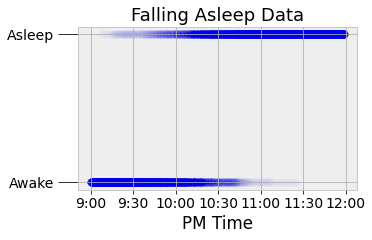

In [7]:
figsize(5, 3)

# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); 
plt.title('Falling Asleep Data', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

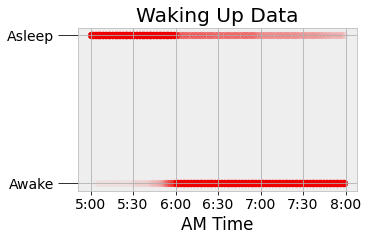

In [8]:
# Wake data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 50, alpha = 0.01, facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('AM Time');
plt.title('Waking Up Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

In [9]:
figsize(20, 8)

# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

In [10]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [63]:
# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 5000

In [64]:
with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed dat
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    #start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling chain 0, 0 divergences: 100%|██████████| 5500/5500 [00:26<00:00, 204.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [65]:
sleep_trace.point

<bound method MultiTrace.point of <MultiTrace: 1 chains, 5000 iterations, 3 variables>>

In [66]:
# Extract the alpha and beta samples
alpha_samples = sleep_trace["alpha"][0:, None]
beta_samples = sleep_trace["beta"][0:, None]

In [67]:
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

In [68]:
alpha_samples

array([[1.02604505],
       [1.02604505],
       [1.02604505],
       ...,
       [0.95821983],
       [0.95821983],
       [0.95821983]])

In [69]:
print('The probability of sleep increases to above 50% at 10:{} PM.'.format(int(time_est[np.where(sleep_est > 0.5)[0][0]][0])))

The probability of sleep increases to above 50% at 10:14 PM.


In [70]:
print('10:00 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(0, beta_est, alpha_est)))
print('9:30  PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(-30, beta_est, alpha_est)))
print('10:30 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(30, beta_est, alpha_est)))

10:00 PM probability of being asleep: 27.49%.
9:30  PM probability of being asleep: 4.83%.
10:30 PM probability of being asleep: 73.90%.


In [71]:
sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = stats.mstats.mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

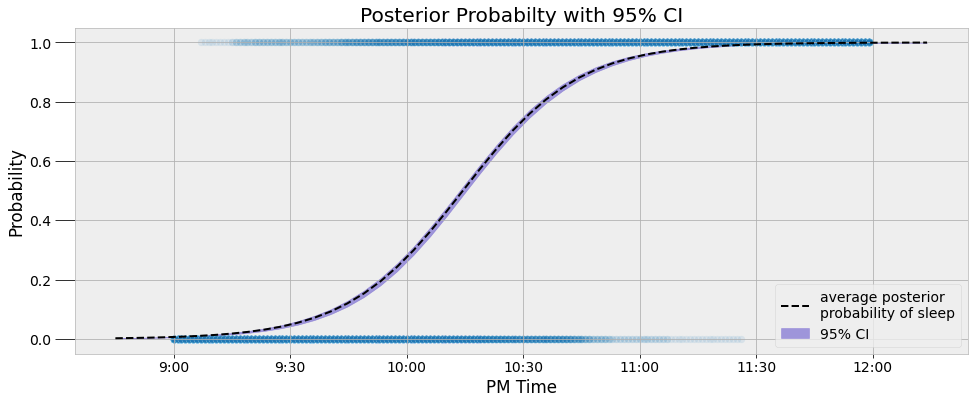

In [72]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, 
                 color='slateblue', label = '95% CI')
plt.plot(time_est, sleep_est, lw=2, ls='--', 
         color='black', label="average posterior \nprobability of sleep")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('PM Time'); plt.ylabel('Probability');
plt.title('Posterior Probabilty with 95% CI');

In [73]:
def sleep_posterior(time_offset, time):
    figsize(16, 8)
    prob = logistic(time_offset, beta_samples, alpha_samples)
    plt.hist(prob, bins=100, histtype='step', lw=4)
    plt.title('Probability Distribution for Sleep at %s PM' % time)
    plt.xlabel('Probability of Sleep'); plt.ylabel('Samples')
    plt.show();

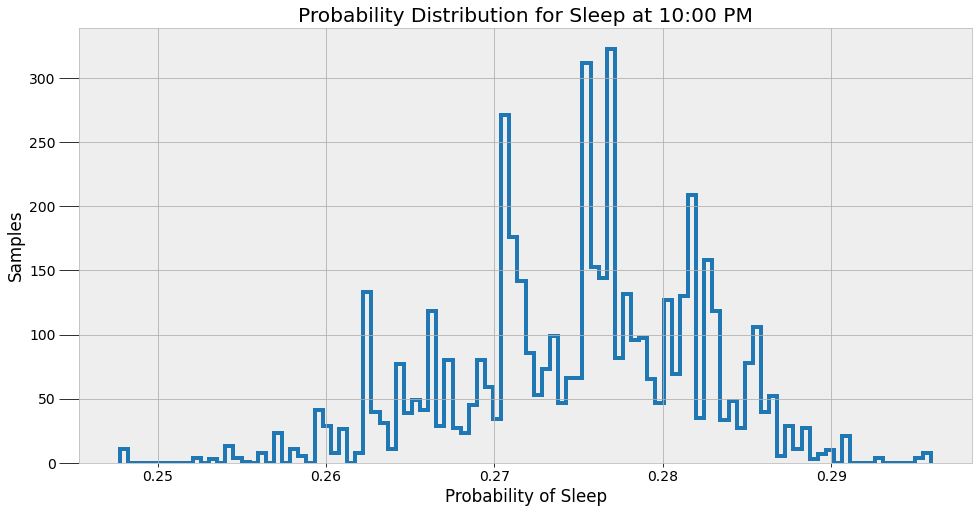

In [74]:
sleep_posterior(0, '10:00')

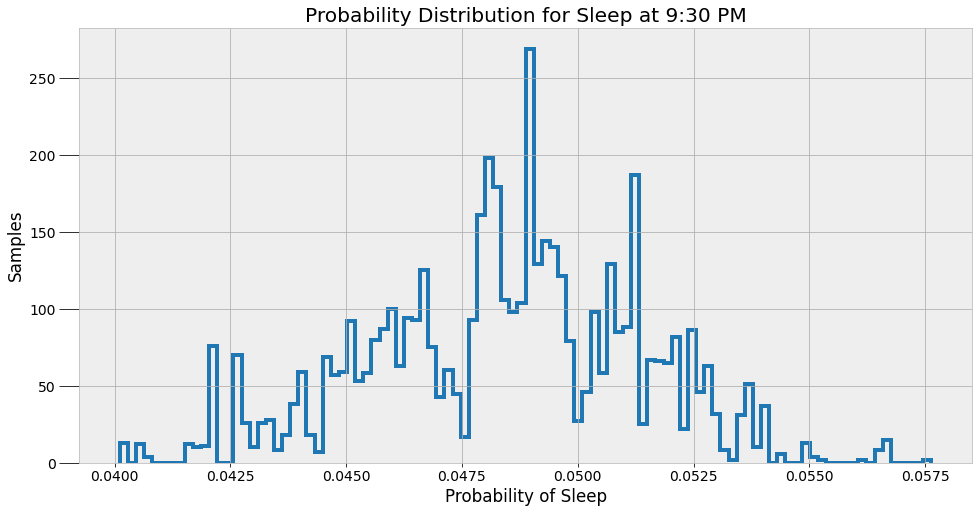

In [75]:
sleep_posterior(-30, '9:30')

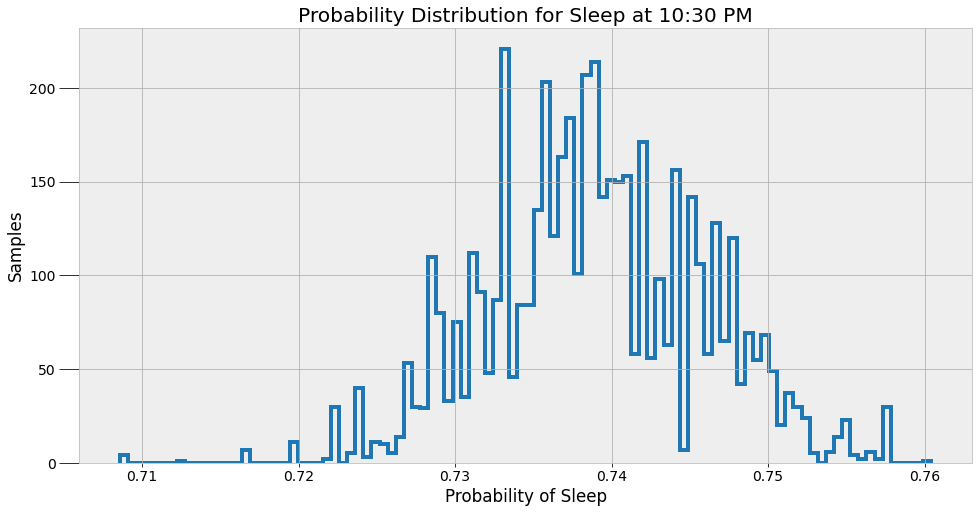

In [76]:
sleep_posterior(30, '10:30')

In [77]:
print('Most likely alpha parameter: {:.6f}.'.format(alpha_est))
print('Most likely beta  parameter: {:.6f}.'.format(beta_est))

Most likely alpha parameter: 0.969704.
Most likely beta  parameter: -0.067013.


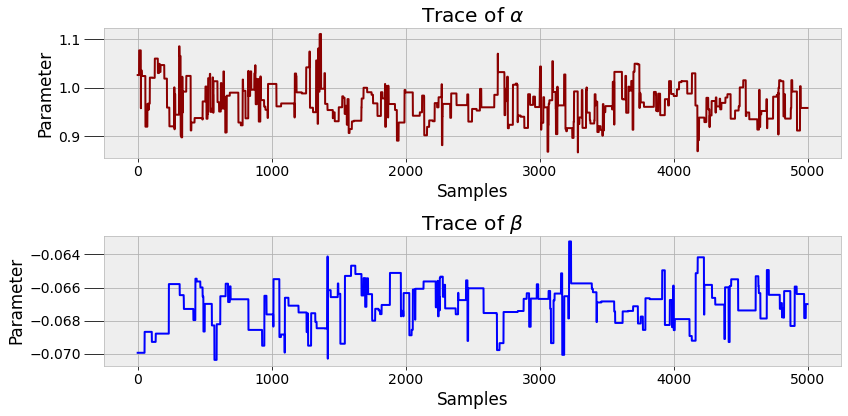

In [78]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

/home/devendra/.local/lib/python3.6/site-packages/arviz/data/base.py:146: UserWarning: More chains (5000) than draws (2). Passed array should have shape (chains, draws, *shape)
  UserWarning,


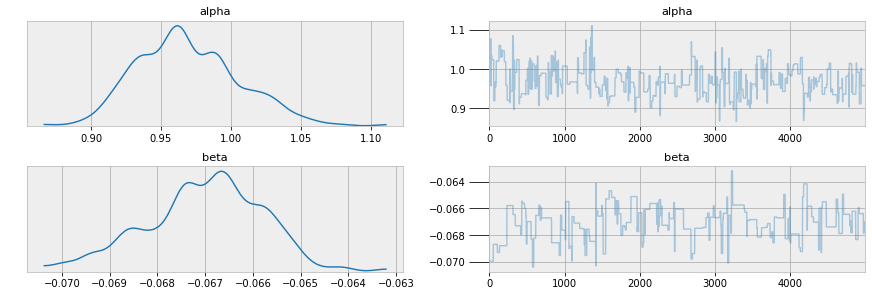

In [79]:
figsize(20, 12)
pm.traceplot(sleep_trace, ['alpha', 'beta']);

/home/devendra/.local/lib/python3.6/site-packages/arviz/data/base.py:146: UserWarning: More chains (5000) than draws (2). Passed array should have shape (chains, draws, *shape)
  UserWarning,


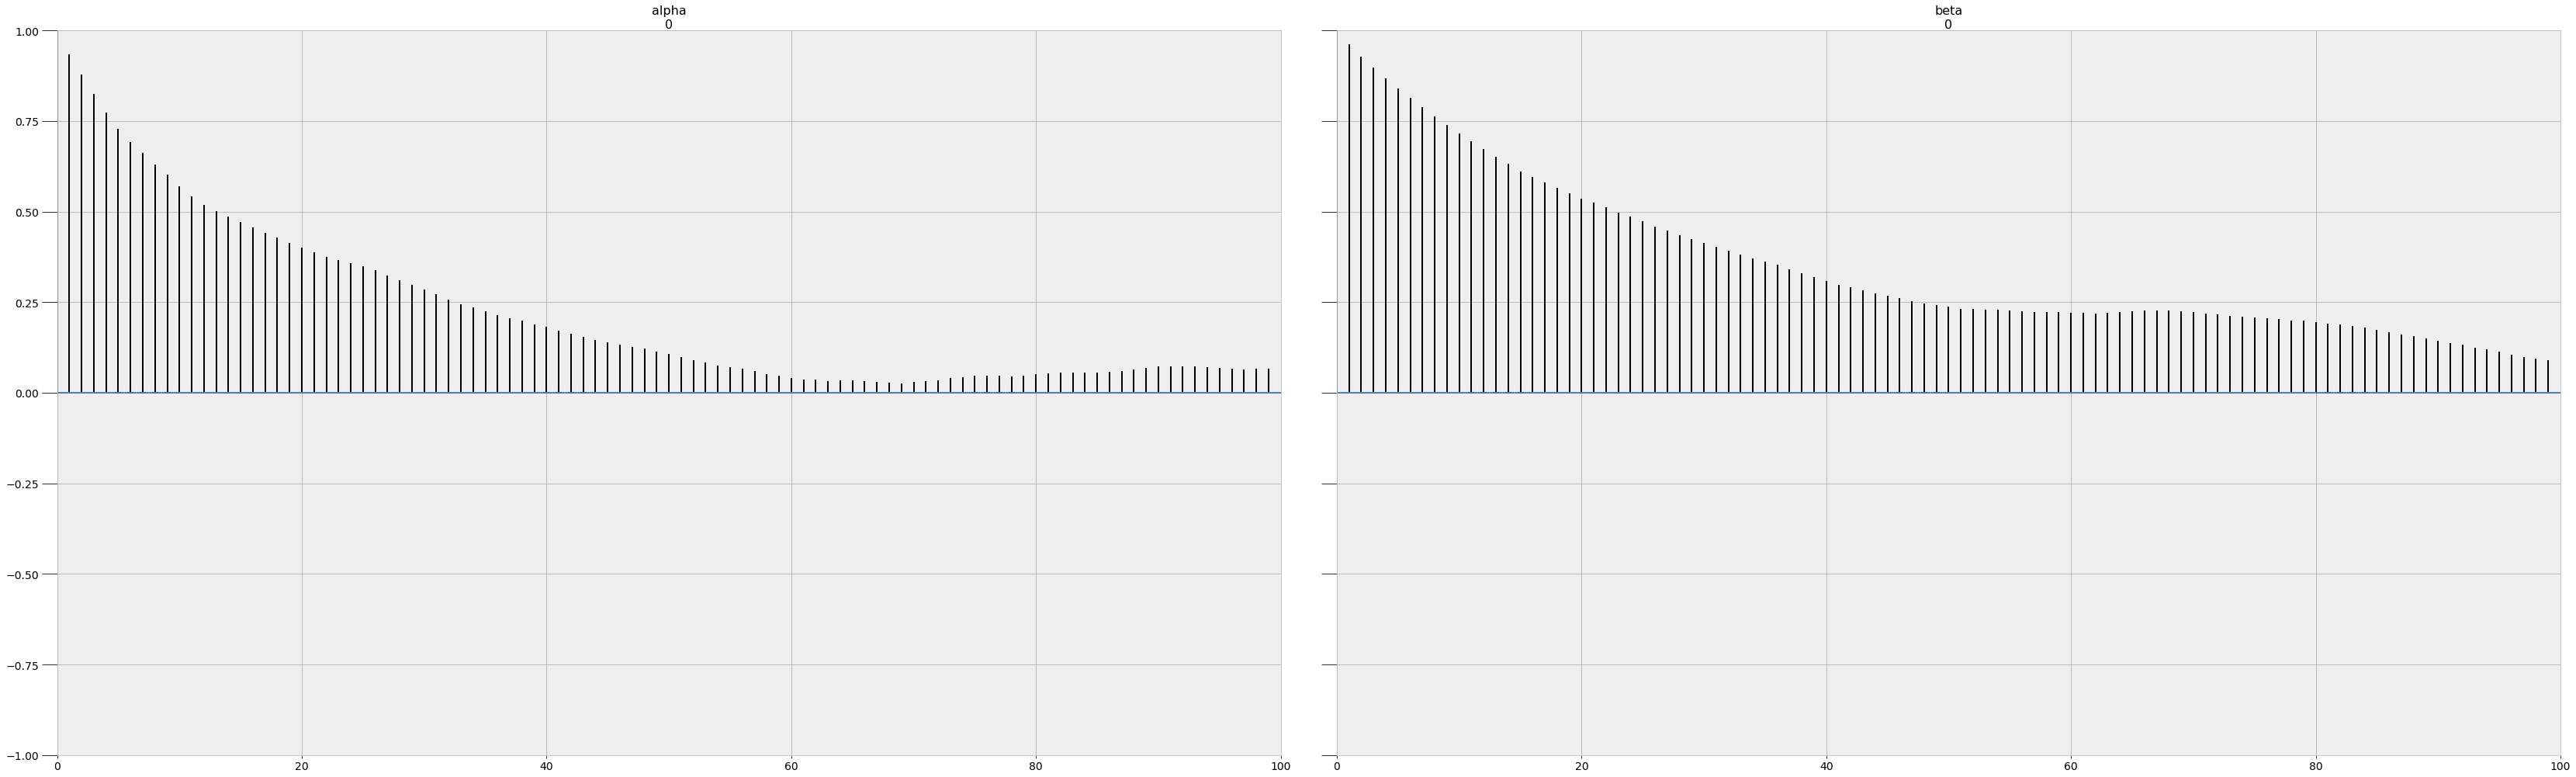

In [80]:
pm.autocorrplot(sleep_trace, ['alpha', 'beta']);

In [81]:
# Sort the values by time offset
wake_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(wake_data.loc[:, 'time_offset'])

# Observations are the indicator
wake_obs = np.array(wake_data.loc[:, 'indicator'])

with pm.Model() as wake_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    wake_trace = pm.sample(N_SAMPLES, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:25<00:00, 430.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [82]:
1e3

1000.0

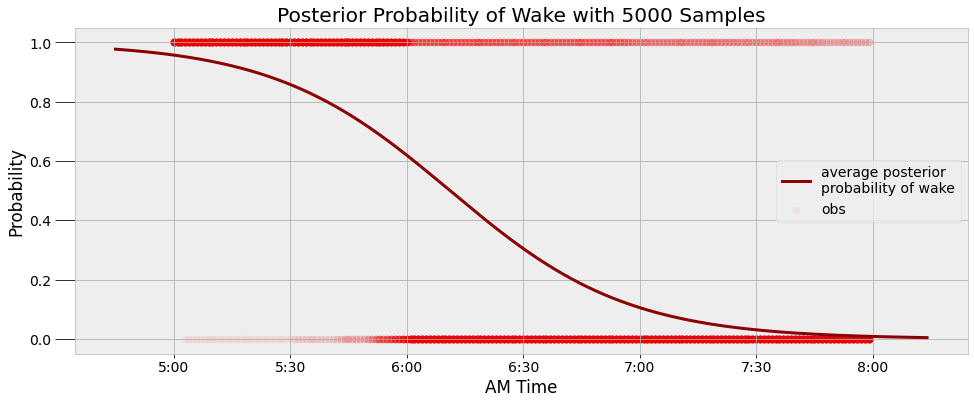

In [83]:
# Extract the alpha and beta samples
alpha_samples = wake_trace["alpha"][5000:, None]
beta_samples = wake_trace["beta"][5000:, None]

# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1000)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
wake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

figsize(16, 6)

plt.plot(time_est, wake_est, color = 'darkred', 
         lw=3, label="average posterior \nprobability of wake")
plt.scatter(time, wake_obs, edgecolor = 'r', facecolor = 'r', 
            s=50, alpha=0.05, label='obs')
plt.title('Posterior Probability of Wake with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probability')
plt.xlabel('AM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

In [84]:
print('The probability of being awake passes 50% at 6:{} AM.'.format(int(time_est[np.where(wake_est < 0.5)][0])))

The probability of being awake passes 50% at 6:11 AM.


In [85]:
print('Probability of being awake at 5:30 AM: {:.2f}%.'.
      format(100 - (100 * logistic(-30, beta=beta_est, alpha=alpha_est))))
print('Probability of being awake at 6:00 AM: {:.2f}%.'.
      format(100 - (100 * logistic(0, beta=beta_est, alpha=alpha_est))))
print('Probability of being awake at 6:30 AM: {:.2f}%.'.
      format(100 - (100 * logistic(30, beta=beta_est, alpha=alpha_est))))

Probability of being awake at 5:30 AM: 14.16%.
Probability of being awake at 6:00 AM: 37.99%.
Probability of being awake at 6:30 AM: 69.49%.


In [87]:
raw_data = pd.read_csv('/home/devendra/pymc3data/data/sleep_wake.csv')
raw_data['length'] = 8 - (raw_data['Sleep'] / 60) + (raw_data['Wake'] / 60)
duration = raw_data['length']

In [88]:
with pm.Model() as duration_model:
    # Three parameters to sample
    alpha_skew = pm.Normal('alpha_skew', mu=0, tau=0.5, testval=3.0)
    mu_ = pm.Normal('mu', mu=0, tau=0.5, testval=7.4)
    tau_ = pm.Normal('tau', mu=0, tau=0.5, testval=1.0)
    
    # Duration is a deterministic variable
    duration_ = pm.SkewNormal('duration', alpha = alpha_skew, mu = mu_, 
                              sd = 1/tau_, observed = duration)
    
    # Metropolis Hastings for sampling
    step = pm.Metropolis()
    duration_trace = pm.sample(N_SAMPLES, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [mu]
>Metropolis: [alpha_skew]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:03<00:00, 2845.97draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [89]:
# Extract the most likely estimates from the sampling
alpha_skew_samples = duration_trace['alpha_skew'][5000:]
mu_samples = duration_trace['mu'][5000:]
tau_samples = duration_trace['tau'][5000:]

alpha_skew_est = alpha_skew_samples.mean()
mu_est = mu_samples.mean()
tau_est = tau_samples.mean()

In [90]:
print('Probability of at least 6.5 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(6.5, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probability of at least 8.0 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(8.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probability of at least 9.0 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(9.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))

Probability of at least 6.5 hours of sleep = 99.14%.
Probability of at least 8.0 hours of sleep = 44.45%.
Probability of at least 9.0 hours of sleep = 11.04%.


The most likely duration of sleep is 7.66 hours.


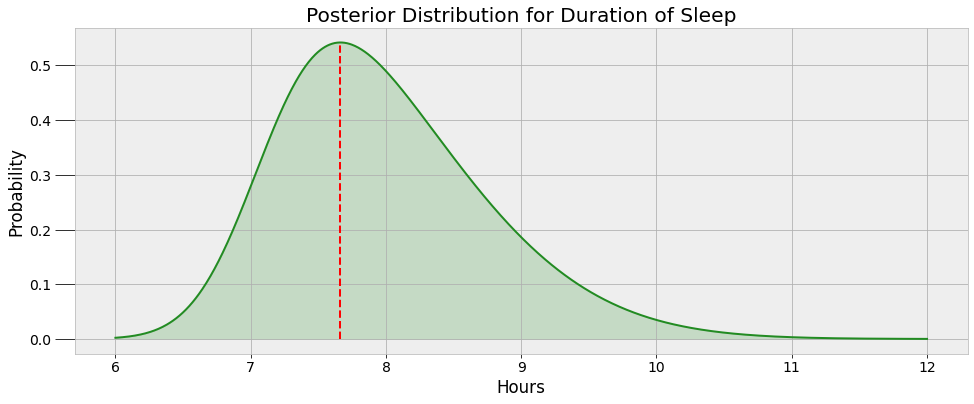

In [91]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
plt.plot(x, y, color = 'forestgreen')
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);
plt.xlabel('Hours'); plt.ylabel('Probability'); 
plt.title('Posterior Distribution for Duration of Sleep');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='red', 
           label = 'Most Likely Duration');

print('The most likely duration of sleep is {:.2f} hours.'.format(x[np.argmax(y)]))